In [210]:
import pandas as pd
import requests
import yfinance as yf
import numpy as np
import time
from tqdm import tqdm
import psycopg2
from datetime import datetime, timedelta
DB_HOST = 'localhost'
DB_NAME = 'tw'
DB_USER = 'mini'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()
uri_pe = "https://www.twse.com.tw/rwd/zh/afterTrading/BWIBBU_d?date=20240809&selectType=ALL"

res = requests.get(uri_pe)
stock_l = res.json()['data']
stock_list = [i[0] for i in stock_l]

"total len of twse stocks: ", len(stock_list)

('total len of twse stocks: ', 1016)

In [211]:
def backtest_code(code, benchmark = 2):
    rolling = 5
    benchmark_index = "^TWII"
    cursor.execute(f"SELECT * from public.stock_price where code in ('{code}', '{benchmark_index}')")
    conn.commit()
    res = cursor.fetchall()
    df = pd.DataFrame(res)
    df.columns = ['da','code', 'cl', 'hi', 'lo', 'op', 'vol', 'adj']
    pivoted = df.pivot(columns='code', values='cl', index='da')
    pivoted.fillna(method='ffill')
    ret = pivoted.pct_change()
    ret['stock_price'] = pivoted[code]
    ret['ret_diff'] = ret[code] - ret[benchmark_index]
    # type 1
    # ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
    # ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
    # ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
    
    # type 2
    ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
    ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
    ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000
    ret['index'] = [i for i in range(len(ret))]

    # check direction
    ret['lag10'] = ret['stock_price'].shift(-4)
    ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]
    ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)

    # check if the direction are the same, if not, tned to not being a mean reversion
    ret['lag10_twii'] = ret[benchmark_index].shift(-4)
    ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
    ret['diff_lag'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)

    # check raise
    ret[f'{code}_lag60'] = ret['stock_price'].shift(-12)
    ret['target_60mins'] = (ret[f'{code}_lag60'] - ret['stock_price'])/ret['stock_price'] * ret['direction']
    ret = ret[(ret['stdize_ret_diff'] >= benchmark) & ret['diff_lag'] == 1][['target_60mins', 'stdize_ret_diff']].dropna()
    return ret

In [212]:
cursor.execute("SELECT DISTINCT code from public.stock_price;")
conn.commit()
list_ = cursor.fetchall()
code_list = [i[0] for i in list_]
dfs = []
for code in tqdm(code_list):
    df = backtest_code(code)
    if len(df) == 0: continue
    dfs.append(df)

100%|██████████| 1017/1017 [02:36<00:00,  6.51it/s]


In [223]:
import numpy as np
import pandas as pd
from scipy import stats
# to test if return after 60 mins are greater than {test}
test = 0.015 # 0.014
final = pd.concat(dfs)
print(len(final))
final = final[final['target_60mins'] != 0.0]
final['target_60mins'] = final['target_60mins'] - test
print(len(final))
mean = final['target_60mins'].mean()
n = len(final)
s = final['target_60mins'].std()

t_statistic = (mean - 0.0) / (s / np.sqrt(n))
print(f"T-statistic: {t_statistic}")

t_stat, p_value = stats.ttest_1samp(final['target_60mins'], 0.0)

if t_stat > 0:
    one_tailed_p_value = p_value / 2
else:
    one_tailed_p_value = 1 - (p_value / 2)

print(f"P-value: {one_tailed_p_value}")

6413
6031
T-statistic: 0.06978688435789497
P-value: 0.47218280028983295


# Single

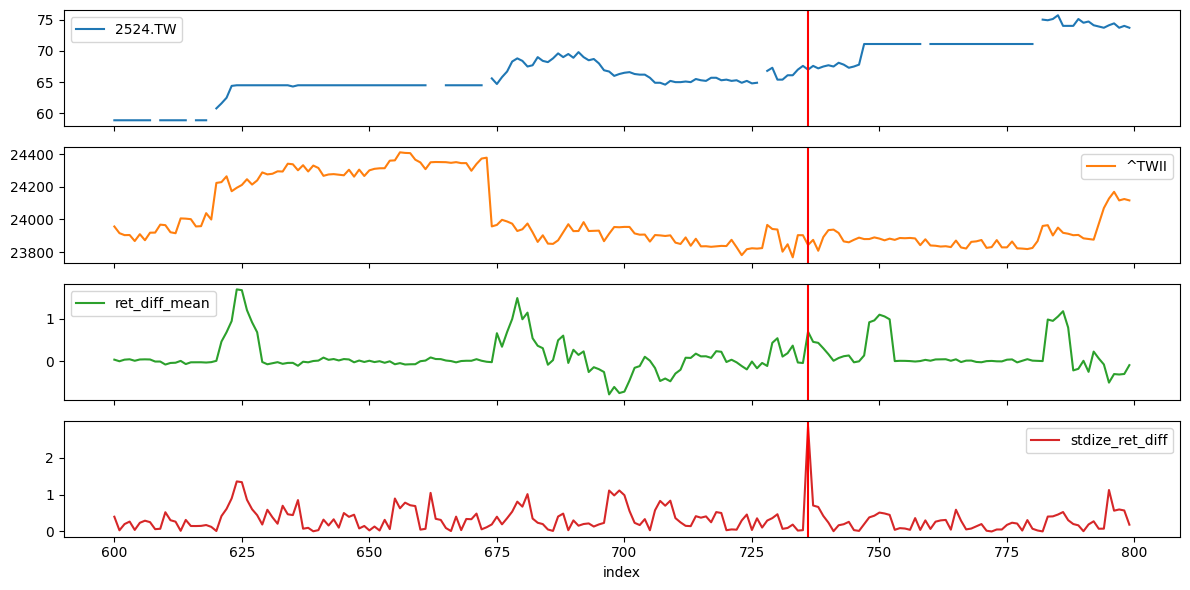

code,2524.TW,^TWII,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,2524.TW_lag60,TWII_lag60,lag10,direction,target_60mins,da
index,,,,,,,,,,,,,
45,56.1,22779.98,-0.004294,0.122421,-0.250995,2.015188,45,55.5,23037.11,55.8,-1,0.011,NaT
545,NaN,23836.45,-0.000272,0.012785,-0.029040,2.250256,545,53.5,23803.17,NaN,1,NaN,NaT
736,67.0,23843.92,0.008969,0.240043,0.693872,2.853251,736,71.1,23880.21,67.7,1,0.061,NaT
1003,68.6,22475.51,-0.013223,0.612192,-1.528708,2.475508,1003,69.8,22167.79,69.6,1,0.017,NaT
1504,93.6,20293.18,-0.003078,0.105293,-0.234110,2.194191,1504,93.6,20575.40,93.6,1,0.000,NaT
1505,93.6,20323.93,-0.002798,0.063700,-0.273269,4.245991,1505,93.6,20613.71,NaN,1,0.000,NaT
1506,93.6,20253.18,-0.001515,0.072041,-0.269126,3.714700,1506,93.6,20628.95,93.6,1,0.000,NaT
1516,93.6,20575.40,-0.002674,0.086931,-0.242129,2.754529,1516,93.6,20545.74,93.6,1,0.000,NaT
1517,93.6,20613.71,-0.002169,0.087661,-0.238762,2.698947,1517,93.6,20482.86,93.6,1,0.000,NaT


In [193]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
code = '2524.TW'
rolling = 5
cursor.execute(f"SELECT * from public.stock_price where code in ('{code}', '^TWII')")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl', 'hi', 'lo', 'op', 'vol', 'adj']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()
ret = pivoted.pct_change()
ret['ret_diff'] = ret[code] - ret['^TWII']
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
ret[code] = pivoted[code].shift(-1)
ret['^TWII'] = pivoted['^TWII'].shift(-1)

ret['index'] = [i for i in range(len(ret))]

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-12)
ret[f'TWII_lag60'] = ret["^TWII"].shift(-12)
ret['lag10'] = ret[code].shift(-4)

ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = abs(np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3))

# ret['signal_defineby_prev_ret'] = 
# specific print
ret['da'] = df['da']
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
start = 600
end = len(ret)
end = 800
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()

# check to long or short
ret[ret['stdize_ret_diff'] >= bm]

array([<Axes: xlabel='da'>, <Axes: xlabel='da'>, <Axes: xlabel='da'>,
       <Axes: xlabel='da'>], dtype=object)

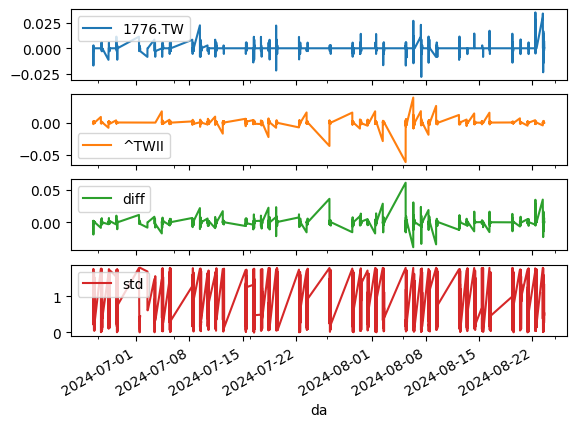

In [24]:
test = pivoted.pct_change().iloc[:, :]
test['diff'] = test['1776.TW'] - test['^TWII']
test['std'] = abs((test['diff'] - test['diff'].rolling(5).mean())/test['diff'].rolling(5).std())
# test.reset_index(drop=True, inplace=True)
test.plot(subplots=True)

In [9]:
ret.iloc[-50:-20, :]

code,1776.TW,^TWII,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,1776.TW_lag60,TWII_lag60,target_60mins,da
da,,,,,,,,,,,
2024-08-23 09:20:00,0.200000,-0.027810,9.043632e-04,1.734356,2.022237,1.165466,2081,0.183099,-0.027977,-0.016901,NaT
2024-08-23 09:25:00,0.200000,-0.028458,6.664975e-04,1.672872,1.330023,0.794655,2082,0.183099,-0.028124,-0.016901,NaT
2024-08-23 09:30:00,0.200000,-0.027696,-7.843166e-04,1.720531,1.278422,0.743495,2083,0.183099,-0.028123,-0.016901,NaT
2024-08-23 09:35:00,0.200000,-0.026559,-1.169643e-03,1.498752,0.659487,0.440804,2084,0.180282,-0.028550,-0.019718,NaT
2024-08-23 09:40:00,0.200000,-0.026380,-1.838912e-04,0.089650,-0.011340,0.124439,2085,0.183099,-0.028551,-0.016901,NaT
2024-08-23 09:45:00,0.200000,-0.027513,1.163976e-03,0.097432,-0.006148,0.075042,2086,0.185915,-0.028505,-0.014085,NaT
2024-08-23 09:50:00,0.200000,-0.028850,1.374402e-03,0.114333,0.008011,0.058042,2087,0.188732,-0.028604,-0.011268,NaT
2024-08-23 09:55:00,0.200000,-0.029128,2.862727e-04,0.103620,0.029422,0.281183,2088,0.185915,-0.027449,-0.014085,NaT
2024-08-23 10:00:00,0.200000,-0.028636,-5.066975e-04,0.082242,0.042681,0.525133,2089,0.188732,-0.026744,-0.011268,NaT
